In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import pickle
import warnings

from scipy.stats import mannwhitneyu
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold

from metaorf.modeling.etl import generate_orf_id, load_features, load_truth_datasets
from metaorf.modeling.ensemble import Dataset, plot_roc_pr, plot_roc, plot_pr

from pathlib import Path

pd.set_option('display.max_columns', 100)

warnings.filterwarnings('ignore')

In [2]:
data_dir = Path('../data').absolute()

### Load truth datasets

In [3]:
truth_pos_df = pd.read_csv(data_dir.joinpath('truthset_positives.240227.tsv'), sep='\t')
truth_neg_df = pd.read_csv(data_dir.joinpath('truthset_negatives.240227.tsv'), sep='\t')

In [4]:
truth_pos_df['orf_id'] = truth_pos_df.apply(lambda x: generate_orf_id(x), axis=1)
truth_neg_df['orf_id'] = truth_neg_df.apply(lambda x: generate_orf_id(x), axis=1)
truth_df = pd.concat([truth_pos_df, truth_neg_df])

In [5]:
datasets = load_truth_datasets(truth_df, data_dir, overwrite=False, dataset_names=['iPSC', 'MB1', 'Gaertner'])

In [6]:
dataset_name = 'all'

ds = datasets[dataset_name]

In [7]:
ds

### Choose model

#### Gradient boosting classifier (standard)

In [8]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.2, 0.5],
    'subsample': [0.8, 0.9, 1.0],
    'loss': ['deviance', 'exponential'],
}

gclf = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, random_state=0, n_jobs=72, n_iter=10)
search = gclf.fit(ds.X, ds.y)
search.best_params_
classifier = GradientBoostingClassifier(**search.best_params_)

In [9]:
search.best_params_

{'subsample': 0.8,
 'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 5,
 'loss': 'exponential',
 'learning_rate': 0.1}

In [10]:
best_params = {'subsample': 0.9,
 'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 0.5,
 'max_depth': 10,
 'loss': 'exponential',
 'learning_rate': 0.05}

In [11]:
classifier = GradientBoostingClassifier(**best_params)
classifier_type = 'gb'

In [12]:
ds.model = classifier

In [13]:
with open(f'../data/top_model_{dataset_name}_gb.pkl', 'wb') as file:
    pickle.dump(ds, file)

#### Random forest classifier

In [14]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree. None means no limit
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Weights associated with classes. 'balanced_subsample' will adjust weights based on the bootstrap sample for every tree grown
}

rclf = RandomizedSearchCV(RandomForestClassifier(), param_grid, random_state=0, n_jobs=36, n_iter=10)
search = rclf.fit(ds.X, ds.y)

In [15]:
search.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': None,
 'bootstrap': False}

In [16]:
classifier = RandomForestClassifier(**search.best_params_)
classifier_type = 'rf'

In [17]:
ds.name

'all'

In [18]:
len(ds.X)

118484

In [46]:
ds.y[0:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

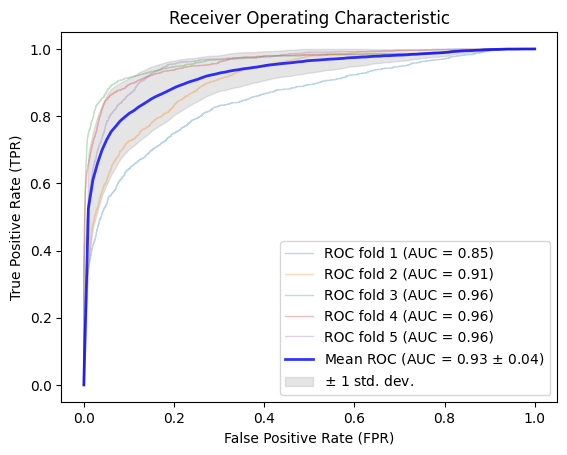

In [19]:
feature_importances, roc_pr_fig = plot_roc(ds, classifier)
roc_pr_fig.savefig(f'../figures/roc_curve_{ds.name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

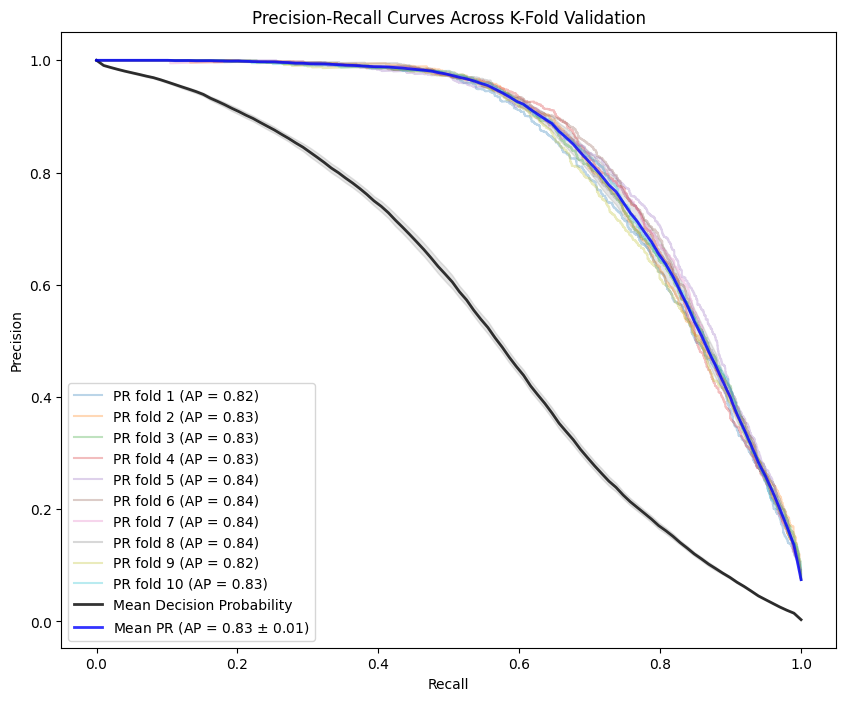

In [20]:
feature_importances, pr_fig = plot_pr(ds.X, ds.y, classifier, n_splits=5)
pr_fig.savefig(f'../figures/pr_curve_{ds.name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

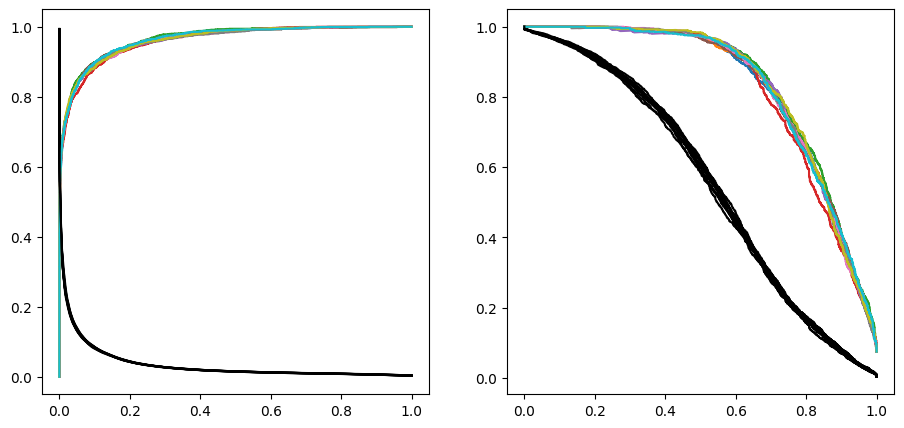

In [21]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
cloned_classifier = clone(classifier)
fig, [ax_roc, ax_pr] = plt.subplots(1, 2, figsize=(11, 5))

for i, (train, test) in enumerate(cv.split(ds.X, ds.y)):
    cloned_classifier.fit(ds.X.iloc[train], ds.y[train])
    fpr, tpr, roc_thresh = roc_curve(ds.y[test], cloned_classifier.predict_proba(ds.X.iloc[test])[:, 1])
    pr, rc, pr_thresh = precision_recall_curve(ds.y[test], cloned_classifier.predict_proba(ds.X.iloc[test])[:, 1])
    
    ax_roc.plot(fpr, tpr)
    ax_roc.plot(fpr, roc_thresh, color='black')

    ax_pr.plot(rc, pr)
    ax_pr.plot(rc, np.append(pr_thresh, 1), color='black')

fig.savefig(f'../figures/roc_pr_threshold_{dataset_name}_gb.png', dpi=200, bbox_inches='tight')

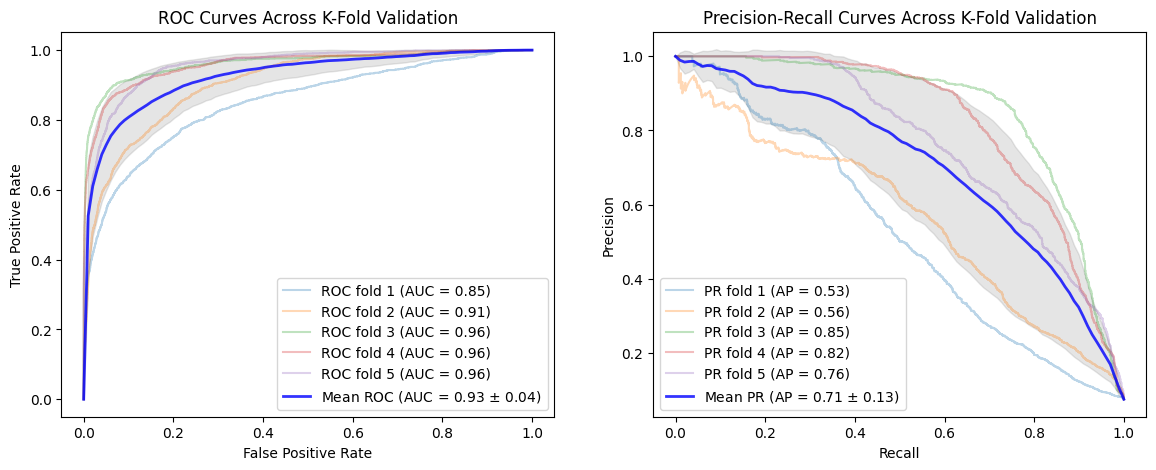

In [22]:
best_model, feature_importances, roc_pr_fig = plot_roc_pr(ds.X, ds.y, classifier, n_splits=5, fpr_cutoff=.2)

In [23]:
roc_pr_fig.get_axes()[1]

<Axes: title={'center': 'Precision-Recall Curves Across K-Fold Validation'}, xlabel='Recall', ylabel='Precision'>

In [24]:
ds.model = classifier.fit(ds.X, ds.y)

In [31]:
roc_pr_fig.savefig(f'../figures/roc_pr_{dataset_name}.png', dpi=200, bbox_inches='tight')

In [29]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=100, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

KeyboardInterrupt: 

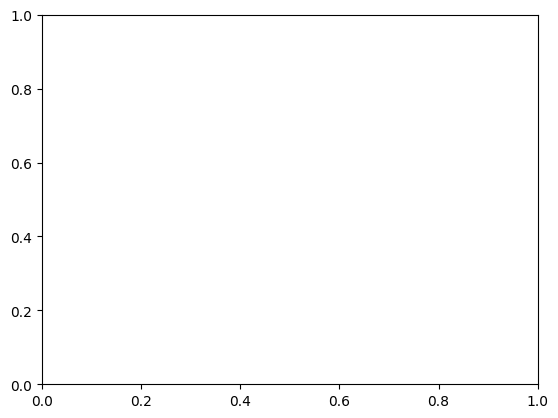

In [30]:
fig, ax = plt.subplots()
plot_permutation_importance(ds.model, ds.X, ds.y, ax)
fig.savefig(f'../figures/feature_importance_{dataset_name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

In [32]:
fi_df = pd.DataFrame(feature_importances, columns=ds.X.columns)
medians = fi_df.median()
sorted_columns = medians.sort_values(ascending=False).index
sorted_df = fi_df[sorted_columns]
plot_df = fi_df.melt(var_name='Category', value_name='Value')

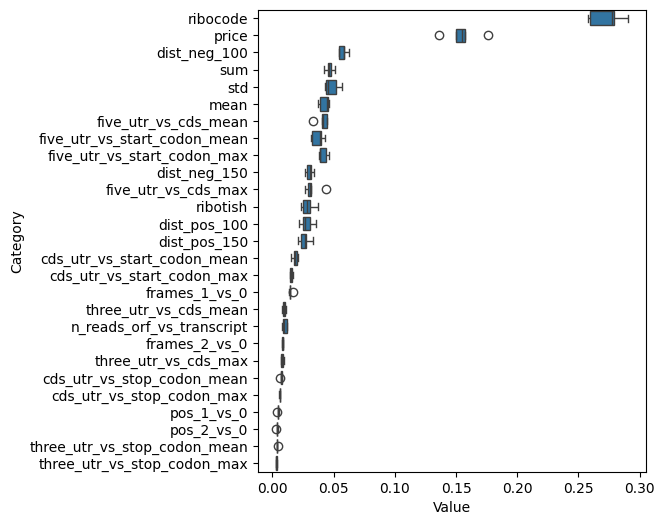

In [33]:
bplot = sns.boxplot(plot_df, y='Category', x='Value', order=sorted_df.columns)
bplot.figure.set_size_inches(5,6)
bplot.figure.savefig(f'../figures/feature_importance_impurity_{dataset_name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

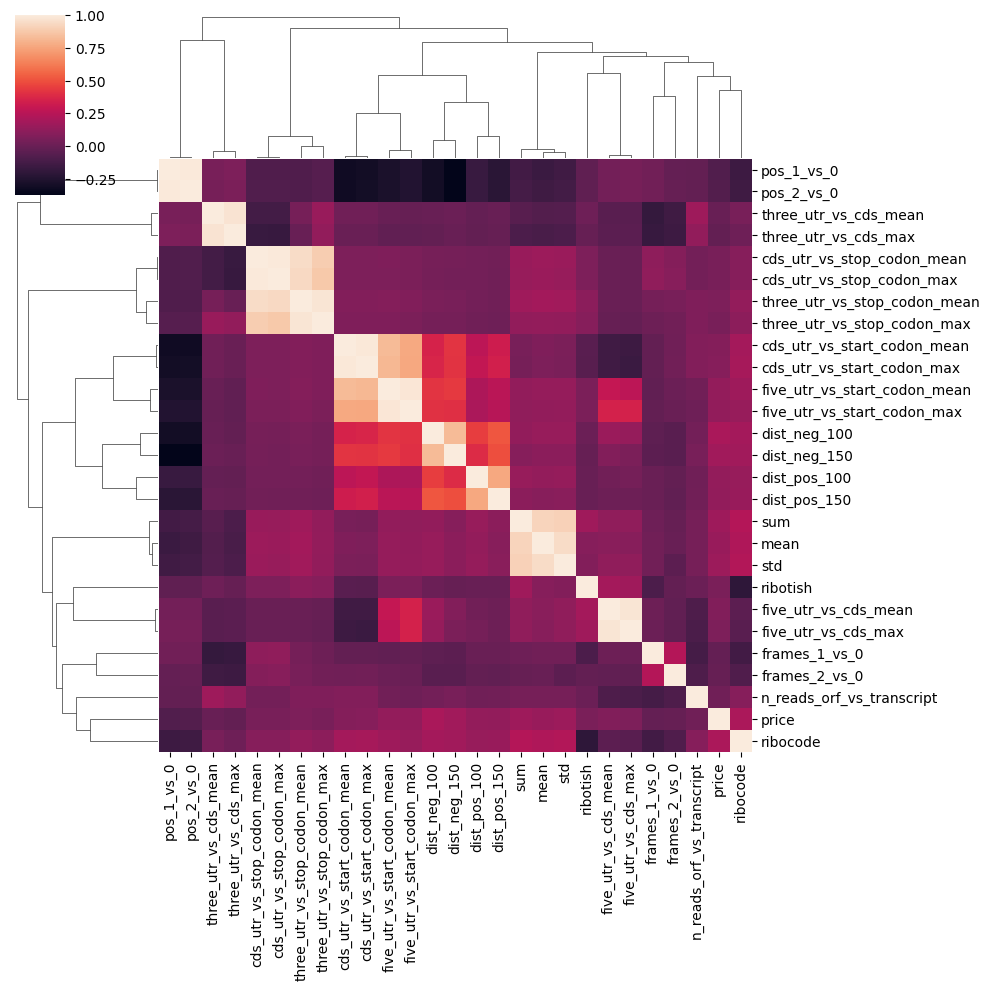

In [34]:
fig = sns.clustermap(ds.X.corr())

In [35]:
fig.savefig(f'../figures/features_heatmap_{dataset_name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

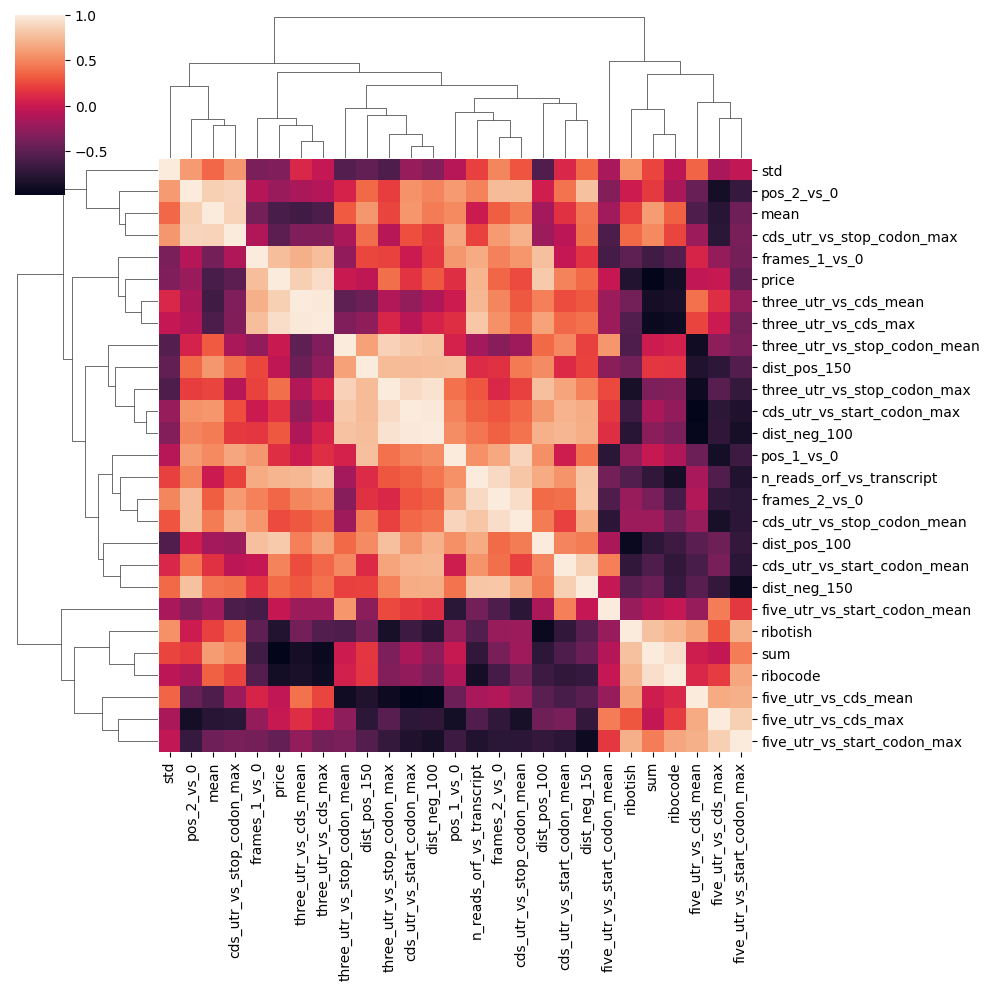

In [36]:
sns.clustermap(fi_df.corr())

In [37]:
cloned_classifier.predict(X)

NameError: name 'X' is not defined

In [38]:
ds.name

'all'

In [39]:
print(classification_report(datasets['Gaertner'].y, best_model.predict(datasets['Gaertner'].X)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     95068
           1       0.92      0.61      0.73      7565

    accuracy                           0.97    102633
   macro avg       0.95      0.80      0.86    102633
weighted avg       0.97      0.97      0.96    102633



In [40]:
print(classification_report(datasets['iPSC'].y, best_model.predict(datasets['iPSC'].X)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8854
           1       0.98      0.70      0.82       697

    accuracy                           0.98      9551
   macro avg       0.98      0.85      0.90      9551
weighted avg       0.98      0.98      0.98      9551



In [41]:
print(classification_report(datasets['Gaertner'].y, best_model.predict(datasets['Gaertner'].X)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     95068
           1       0.92      0.61      0.73      7565

    accuracy                           0.97    102633
   macro avg       0.95      0.80      0.86    102633
weighted avg       0.97      0.97      0.96    102633



In [42]:
print(classification_report(datasets['MB1'].y, best_model.predict(datasets['MB1'].X)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5727
           1       0.97      0.54      0.69       573

    accuracy                           0.96      6300
   macro avg       0.96      0.77      0.84      6300
weighted avg       0.96      0.96      0.95      6300



In [43]:
with open(filename, 'wb') as file:
    pickle.dump(data, file)

NameError: name 'filename' is not defined

In [ ]:
ds = datasets['all']

KeyboardInterrupt: 

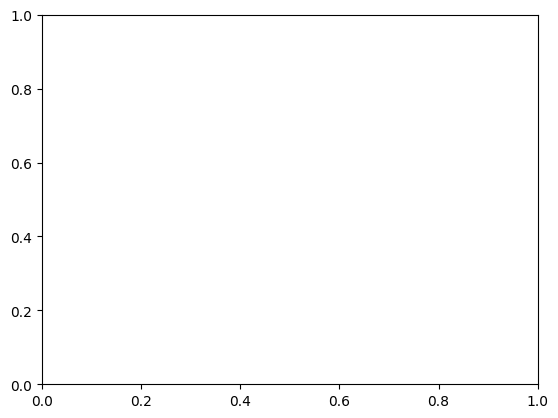

In [44]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots()

score_name = 'balanced_accuracy'

common_params = {
    "X": ds.X,
    "y": ds.y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=100, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 72,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": score_name,
}

LearningCurveDisplay.from_estimator(classifier, **common_params, ax=ax, scoring=score_name)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
fig.savefig(f'../figures/learning_curve_{dataset_name}_{score_name}_{classifier_type}.png', dpi=200, bbox_inches='tight')

In [ ]:
feature_df = ds.X
feature_df['outcome'] = ds.y
feature_df['orf_ids'] = ds.orf_ids

In [ ]:
feature_df.columns

In [ ]:
feature = 'price'

ax = sns.histplot(data=feature_df, x=feature, hue='outcome', 
             multiple='stack', stat="density", common_norm=False, kde=True)

array1 = feature_df[feature_df['outcome'] == 1][feature]
array2 = feature_df[feature_df['outcome'] == 0][feature]

u_stat, p_value = mannwhitneyu(array1, array2, alternative='two-sided')

ax.figure.savefig(f'../figures/feature_histogram_{feature}_{dataset}_{classifier_type}.png', dpi=200, bbox_inches='tight')